# Surface water mass transformation (WMT) analysis using `xwmt`

In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import numpy as np
import pandas as pd
import xarray as xr
import xgcm
import xwmt
import xbudget
import xhistogram
from xhistogram.xarray import histogram
import os

# Optional (loading to memory and plotting) 
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
import calendar

In [28]:
print(
    'numpy version',np.__version__, '\npandas version',pd.__version__,
    '\nxarray version',xr.__version__, '\nxhistogram version',xhistogram.__version__, '\nxgcm version',xgcm.__version__,
    '\nxwmt version',xwmt.__version__, '\nxbudget version',xbudget.__version__,)

numpy version 1.22.4 
pandas version 1.5.2 
xarray version 2022.12.0 
xhistogram version 0.3.1 
xgcm version 0.1.dev565+g7492277 
xwmt version 0.0.3 
xbudget version 0.0.1


### Loading a dataset

Update `rootdir` with your own dataset's path. All relevant variables will be loaded into `ds` and the (static) grid data will be loaded into a separate dataset. Note that the time period (`tprd`) is `'201001-201412'` such that only the last five years of the CM4 historical run are used. In order to include more years, you can use wildcard `*` for `tprd` instead.

In [29]:
rootdir = '/data_cmip6/CMIP6'
activity_id = 'CMIP'
institution_id = 'NOAA-GFDL'
source_id = 'GFDL-CM4'
experiment_id = 'historical'
member_id = 'r1i1p1f1'
table_id = 'Omon'
grid_label = 'gn'
version = 'v20180701'
tprd = '201001-201412'
#tprd = '*'

ncdir = os.path.join(rootdir,activity_id,institution_id,source_id,experiment_id,member_id,table_id)

In [30]:
variables = ['tos','sos','hfds','wfo','sfdsi']
chunks = {'time':1, 'x':-1, 'y':-1, 'xh':-1, 'yh':-1}

ds = xr.Dataset()
for var in variables:
    filepath = os.path.join(ncdir,var,grid_label,version)
    filename = '_'.join([var,table_id,source_id,experiment_id,member_id,grid_label,tprd])+'.nc'
    
    if os.path.isdir(filepath):
        print('Loading',filename)
        ds[var] = xr.open_mfdataset(filepath+'/'+filename,use_cftime=True, chunks=chunks)[var]
    else:
        print('Path for',var,'does not exist. Skipping.')

Loading tos_Omon_GFDL-CM4_historical_r1i1p1f1_gn_201001-201412.nc
Loading sos_Omon_GFDL-CM4_historical_r1i1p1f1_gn_201001-201412.nc
Loading hfds_Omon_GFDL-CM4_historical_r1i1p1f1_gn_201001-201412.nc
Loading wfo_Omon_GFDL-CM4_historical_r1i1p1f1_gn_201001-201412.nc
Path for sfdsi does not exist. Skipping.


In [31]:
grid = []
for var in ['areacello','deptho','basin']:
    filepath = os.path.join(ncdir.replace(table_id,'Ofx'),var,grid_label,version)
    filename = '_'.join([var,'Ofx',source_id,experiment_id,member_id,grid_label])+'.nc'
    
    if os.path.isdir(filepath):
        print('Loading',filename)
        grid.append(xr.open_mfdataset(filepath+'/'+filename,use_cftime=True, chunks=chunks))
    else:
        print('Path for',var,'does not exist. Skipping.')

Loading areacello_Ofx_GFDL-CM4_historical_r1i1p1f1_gn.nc
Loading deptho_Ofx_GFDL-CM4_historical_r1i1p1f1_gn.nc
Loading basin_Ofx_GFDL-CM4_historical_r1i1p1f1_gn.nc


In [32]:
ds = xr.merge([ds, xr.merge(grid[1:])])

# Area needs to be loaded seperately after renaming MOM6-specific dimension names (xh, yh) 
ds['areacello'] = grid[0].areacello.rename({'xh': 'x', 'yh': 'y'})

In [33]:
# Add core coordinates of ocean_grid to ds
ds = ds.assign_coords({
    "areacello": xr.DataArray(ds["areacello"].values, dims=('y', 'x',)), # Required for area-integration
    "lon":       xr.DataArray(ds["lon"].values, dims=('y', 'x',)), # Required for calculating density if not already provided!
    "lat":       xr.DataArray(ds["lat"].values, dims=('y', 'x',)), # Required for calculating density if not already provided!
})

# xgcm grid for dataset
coords = {
    'X': {'center': 'x',},
    'Y': {'center': 'y',},
}
metrics = {
    ('X','Y'): "areacello", # Required for area-integration
}
grid = xgcm.Grid(ds, coords=coords, metrics=metrics, boundary={'X':'periodic', 'Y':'periodic'}, autoparse_metadata=False)

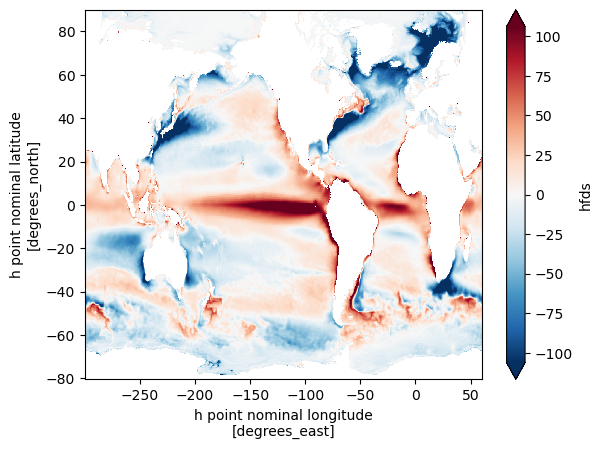

In [34]:
grid._ds['hfds'].mean('time').plot(robust=True)

In [35]:
budgets_dict = {
    "mass": {},
    "heat": {"surface_lambda": "tos"},
    "salt": {"surface_lambda": "sos"}
}

In [36]:
swmt = xwmt.WaterMassTransformations(grid, budgets_dict)

In [37]:
bins = xr.DataArray(np.arange(-4., 50., 1.), dims=('tos_bin'))

### Benchmarking `integrate_transformations`

In [38]:
%%time
tmp_xhistogram_global = histogram(
    swmt.grid._ds['tos'].expand_dims('z_l'),
    bins=[bins.values],
    dim=['x', 'y', 'z_l'],
    weights=swmt.grid._ds['hfds'].fillna(0.).expand_dims('z_l'),
).mean('time')
tmp_xhistogram_global.load();
;

CPU times: user 6.85 s, sys: 1.16 s, total: 8.01 s
Wall time: 3.83 s


''

In [39]:
%%time
tmp_xgcm = swmt.grid.transform(
    swmt.grid._ds['hfds'].fillna(0.).expand_dims('z_l'),
    "Z",
    target=bins,
    target_data=swmt.grid._ds['tos'].expand_dims({'z_i': xr.DataArray([0,1], dims=('z_i',))}),
    method="conservative",
    
).sum(['x','y']).mean('time')
tmp_xgcm.load();
;

/work2/hfd/codedev/xgcm/xgcm/transform.py:245: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(


CPU times: user 57.2 s, sys: 2min 17s, total: 3min 14s
Wall time: 38.7 s


''

In [40]:
%%time
tmp_xhistogram_sumlocal = histogram(
    swmt.grid._ds['tos'].expand_dims('z_l'),
    bins=[bins.values],
    dim=['z_l'],
    weights=swmt.grid._ds['hfds'].fillna(0.).expand_dims('z_l'),
).sum(['x', 'y']).mean('time')
tmp_xhistogram_sumlocal.load();
;

CPU times: user 1min 25s, sys: 5min 50s, total: 7min 15s
Wall time: 1min 18s


''


Global sum to assess heat conservation:
- Raw surface flux: -5876007.5 
 - Global xhistogram: -5876008.0 
 - Local xgcm -5875968.5 
 - Local xhistogram -5875997.5


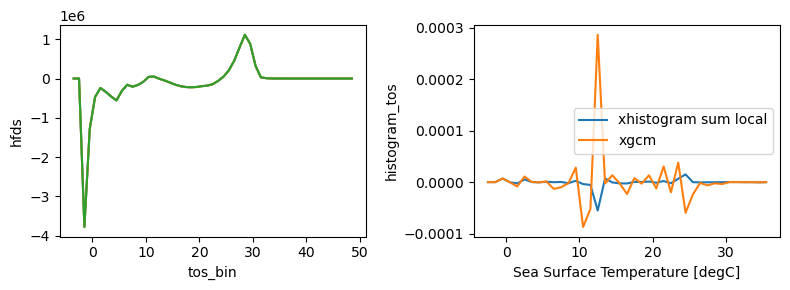

In [41]:
plt.figure(figsize=(8, 3))
plt.subplot(1,2,1)
plt.title("Error relative to global `xhistogram` calculation")
tmp_xhistogram_global.plot(label="xhistogram")
tmp_xhistogram_sumlocal.plot(label="xhistogram")
tmp_xgcm.plot(label="xhistogram")

plt.subplot(1,2,2)
plt.title("Error relative to global `xhistogram` calculation")
((tmp_xhistogram_global - tmp_xhistogram_sumlocal.values)/tmp_xhistogram_global).plot(label="xhistogram sum local")
((tmp_xhistogram_global - tmp_xgcm.values)/tmp_xhistogram_global).plot(label="xgcm")
plt.legend()
plt.tight_layout()

print()
print(
    "Global sum to assess heat conservation:\n"
    "- Raw surface flux:", grid._ds['hfds'].mean('time').sum().values,"\n",
    "- Global xhistogram:", tmp_xhistogram_global.sum().values,"\n",
    "- Local xgcm", tmp_xgcm.sum().values,"\n",
    "- Local xhistogram", tmp_xhistogram_sumlocal.sum().values
)

### Benchmarking `map_transformations` for a single slice

In [42]:
tos_lev = 12.5

In [43]:
%%time
tmp_xgcm_isosurface = swmt.grid.transform(
    swmt.grid._ds['hfds'].fillna(0.).expand_dims('z_l'),
    "Z",
    target=bins,
    target_data=swmt.grid._ds['tos'].expand_dims({'z_i': xr.DataArray([0,1], dims=('z_i',))}),
    method="conservative"
).sel({"tos_bin":tos_lev}, method="nearest").mean('time')
tmp_xgcm_isosurface.load();
;

/work2/hfd/codedev/xgcm/xgcm/transform.py:245: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(


CPU times: user 25.5 s, sys: 41.7 s, total: 1min 7s
Wall time: 14.8 s


''

In [44]:
%%time
tmp_xhistogram_isosurface = histogram(
    swmt.grid._ds['tos'].expand_dims('z_l'),
    bins=[bins.values],
    dim=['z_l'],
    weights=swmt.grid._ds['hfds'].fillna(0.).expand_dims('z_l'),
).sel({"tos_bin":tos_lev}, method="nearest").mean('time')
tmp_xhistogram_isosurface.load();
;

CPU times: user 1min 14s, sys: 3min 40s, total: 4min 55s
Wall time: 43.9 s


''

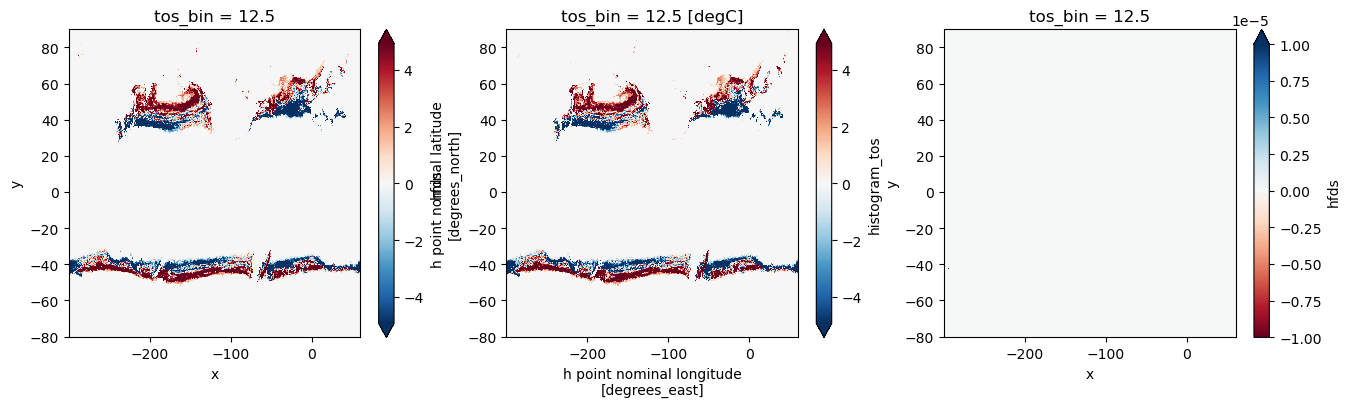

In [45]:
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
tmp_xgcm_isosurface.plot(robust=True)
plt.subplot(1,3,2)
tmp_xhistogram_isosurface.plot(robust=True)
plt.subplot(1,3,3)
(tmp_xgcm_isosurface - tmp_xhistogram_isosurface.values).plot(vmin=-1.e-5, vmax=1.e-5, cmap="RdBu")

### Benchmarking `map_transformations` for full 3D fields

In [46]:
%%time
tmp_xgcm_isosurfaces = swmt.grid.transform(
    swmt.grid._ds['hfds'].fillna(0.).expand_dims('z_l'),
    "Z",
    target=bins,
    target_data=swmt.grid._ds['tos'].expand_dims({'z_i': xr.DataArray([0,1], dims=('z_i',))}),
    method="conservative"
).mean('time')
tmp_xgcm_isosurfaces.load();
;

/work2/hfd/codedev/xgcm/xgcm/transform.py:245: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(


CPU times: user 1min 57s, sys: 3min 20s, total: 5min 17s
Wall time: 1min 17s


''

In [47]:
%%time
tmp_xhistogram_isosurfaces = histogram(
    swmt.grid._ds['tos'].expand_dims('z_l'),
    bins=[bins.values],
    dim=['z_l'],
    weights=swmt.grid._ds['hfds'].fillna(0.).expand_dims('z_l'),
).mean('time')
tmp_xhistogram_isosurfaces.load();
;

CPU times: user 2min 29s, sys: 6min 3s, total: 8min 32s
Wall time: 1min 42s


''

There are some very minor discrepancies between the two regridding methods. They are not noticeable by eye, but the coordinate transformations differ quantitatively in a handful of cells. I do not yet understand why that would be.

In [48]:
imax = (tmp_xhistogram_isosurfaces!=tmp_xgcm_isosurfaces).sum(['x','y']).argmax()

In [49]:
(tmp_xhistogram_isosurfaces!=tmp_xgcm_isosurfaces).sum(['x','y'])

<xarray.DataArray (tos_bin: 53)>
array([0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 2, 5, 0, 2, 2, 1, 2, 1, 2, 0, 2, 1,
       1, 1, 2, 3, 3, 4, 3, 4, 3, 8, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0])
Coordinates:
  * tos_bin  (tos_bin) float64 -3.5 -2.5 -1.5 -0.5 0.5 ... 45.5 46.5 47.5 48.5

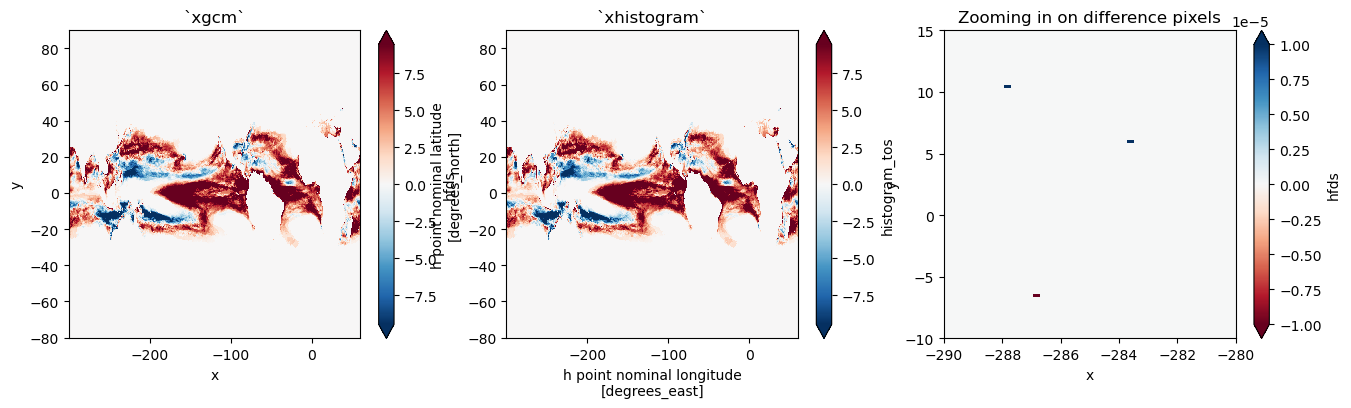

In [50]:
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
tmp_xgcm_isosurfaces.isel(tos_bin=imax).plot(robust=True)
plt.title("`xgcm`")
plt.subplot(1,3,2)
tmp_xhistogram_isosurfaces.isel(tos_bin=imax).plot(robust=True)
plt.title("`xhistogram`")
plt.subplot(1,3,3)
(tmp_xgcm_isosurfaces.isel(tos_bin=imax) - tmp_xhistogram_isosurfaces.isel(tos_bin=imax).values).plot(vmin=-1.e-5, vmax=1.e-5, cmap="RdBu")
plt.ylim(-10, 15)
plt.xlim(-290, -280)
plt.title("Zooming in on difference pixels");

### Takeaways from benchmarking analysis

Assuming these results scale similarly for larger calculations, these results suggest that `xhistogram` should be the default method for the area-integrated `integrate_transformations` method of `xwmt.WaterMassTransformations`, while `xgcm` should be the default method for `map_transformations`.